# Uso de MODELOS GAM

## IMPORTAR LIBRERÍAS 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
np.random.seed(123)

In [2]:
cars = pd.read_csv('mtcars.csv', index_col = 0)
print(cars.shape)
X = cars.drop(columns = 'mpg')
y = cars.mpg

(32, 11)


## Data Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop(columns = 'mpg'), cars.mpg, test_size = 0.3, random_state = 123)

# Función de Modelado

Esta función incluirá todo el proceso de entrenamiento y predicción. Además se puede entregar el parámetro de regresión o clasificación para entregar las métricas de evaluación adecuadas.

In [4]:
def compute_model(model, task):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if task == 'r':
        #r2 = r2_score(y_pred, y_test)
        RMSE = np.sqrt(mean_squared_error(y_pred,y_test))
        
        #print(f'R2 test: {r2}')
        print(f'RMSE test: {RMSE}')
    elif task == 'c':
        accuracy = accuracy_score(y_pred,y_test)
        print(f'Accuracy {accuracy}')


# Regression 

# Primer Approach

In [5]:
gam_lineal = LinearGAM()
compute_model(gam_lineal, 'r')

RMSE test: 3.8917211370336364


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [6]:
gam_lineal.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.4536
Link Function:                     IdentityLink Log Likelihood:                                   -69.1829
Number of Samples:                           22 AIC:                                               147.273
                                                AICc:                                             150.2087
                                                GCV:                                               12.2261
                                                Scale:                                              8.8286
                                                Pseudo R-Squared:                                   0.8104
Feature Function                  Lam

C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [7]:
gam_lineal.n_splines # hiperparámetro de número de splines

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

In [8]:
gam_lineal.lam # hiperparámetro de regularización lambda

[[0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6]]

## Curvas de Dependencia Parcial

Estas curvas permiten ver cuál es la contribución de cada una de las variables al Target (Vector Objetivo)

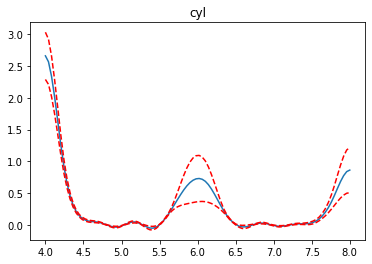

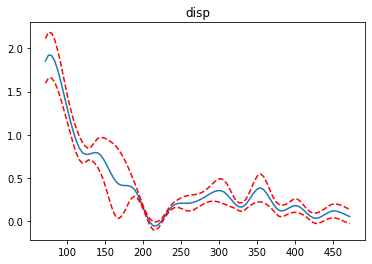

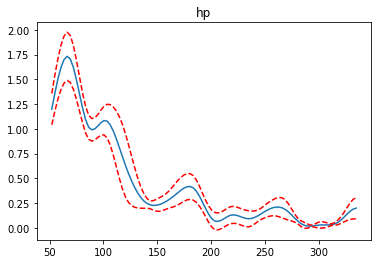

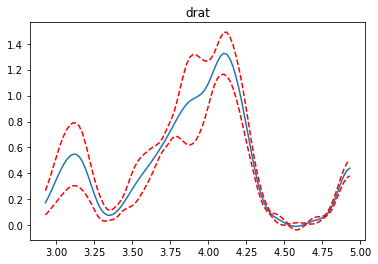

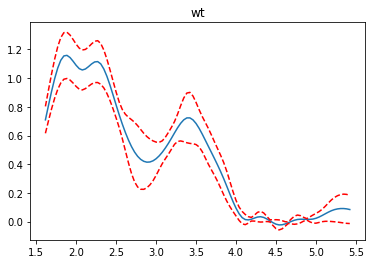

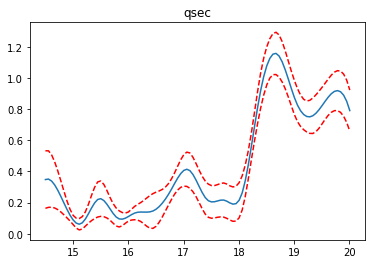

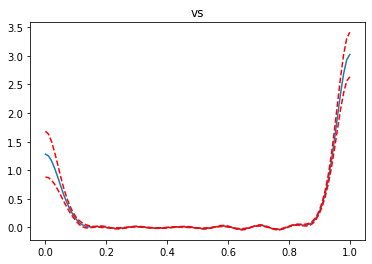

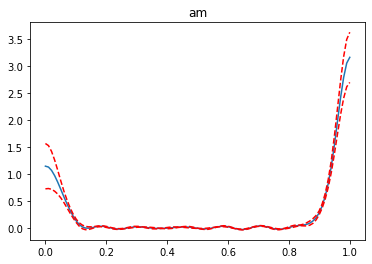

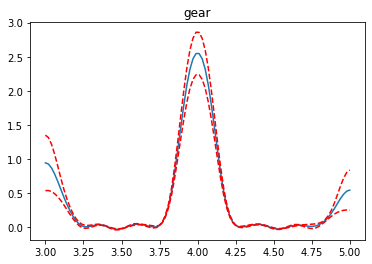

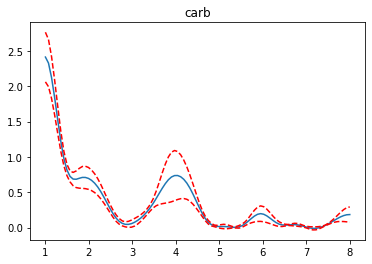

In [9]:
def partial_dependence(model, data):
    for i, term in enumerate(model.terms):
        if term.isintercept:
            continue
        titles = data.columns 
        XX = model.generate_X_grid(term=i) #GENERA UNA GRILLA DEL EJE X
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95) #GENERA UNA GRILLA DEL EJE Y además de los intervalos de confianza

        plt.figure()
        plt.plot(XX[:, term.feature], pdep) # plot función
        plt.plot(XX[:, term.feature], confi, c='r', ls='--') #plot CI
        plt.title(titles[i]) # fija los títulos
        
    return plt.show()
    
partial_dependence(gam_lineal, X_train)

## Función alternativa de Ploteo

Esta función permite mostrar todas Curvas de Dependencia parcial en un estilo FacetGrid

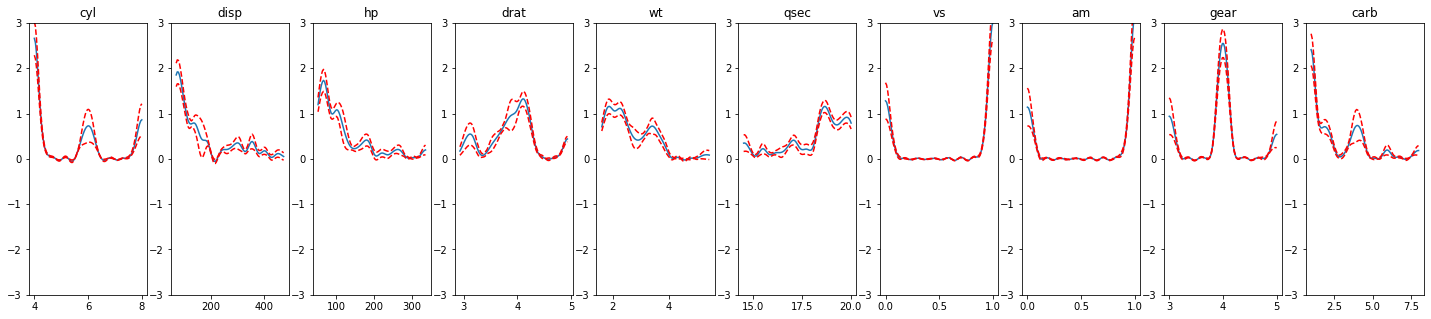

In [10]:
def partial_dependence_grid(model, data, w = 25, h = 5, conf = 0.95, y_range = (-10,10)):
    fig, axs = plt.subplots(1,data.shape[1], figsize=(w,h)); # diseño de la grilla
    titles = X_train.columns #nombre de la grilla
    
    for i, ax in enumerate(axs):      
        XX = model.generate_X_grid(term=i) #GENERA UNA GRILLA DEL EJE X
        ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX)) # GENERA UN PLOT DEL EJE X VS EJE Y 
        ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--') # INTERVALO DE CONFIANZA
        ax.set_title(titles[i]) # COLOCA TÍTULOS
        
        if y_range != None:
            ax.set_ylim(y_range[0],y_range[1])
    
    return plt.show()

partial_dependence_grid(gam_lineal, X_train, y_range = (-3,3))

# Hiperparámetros

La idea es poder ver el efecto de los hiperparámetros al momento de ajustar el modelo.

In [11]:
lgam2 = LinearGAM(n_splines = 9, lam = 0) # 2 hiperparámetros: n_splines y lam: regularización
compute_model(lgam2,'r')

RMSE test: 5.309168851775487


In [12]:
lgam2.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                        22.0
Link Function:                     IdentityLink Log Likelihood:                                   287.6068
Number of Samples:                           22 AIC:                                             -529.2137
                                                AICc:                                           -1081.2141
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


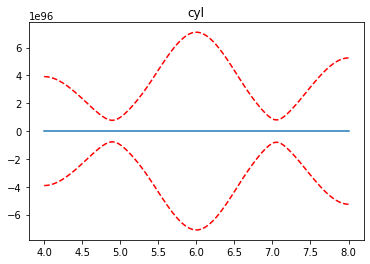

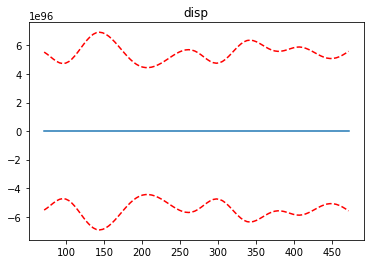

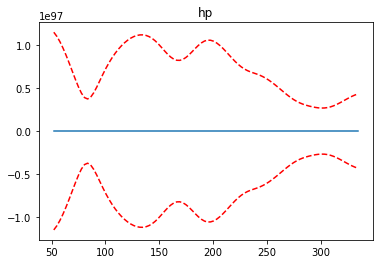

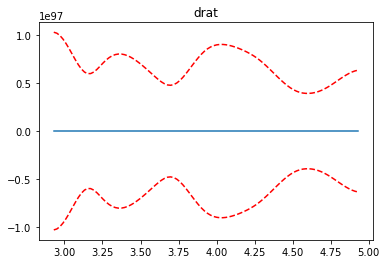

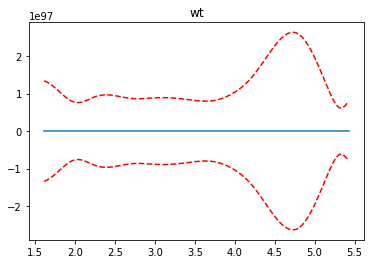

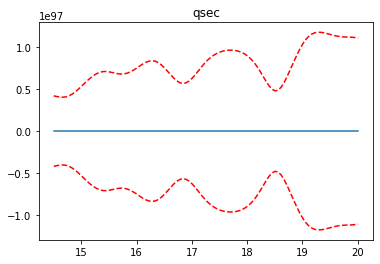

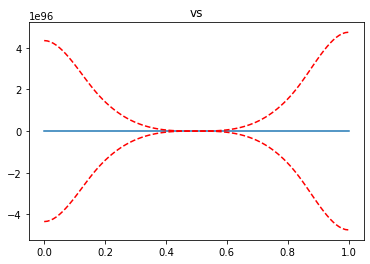

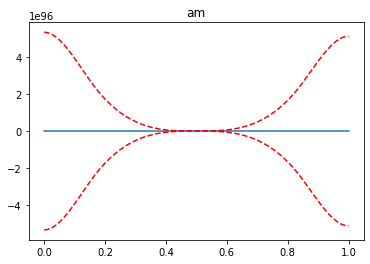

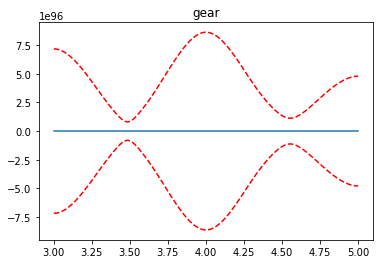

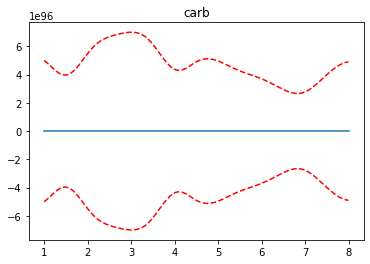

In [13]:
partial_dependence(lgam2, X_train)

# GridSearch

pyGAM incluye un GridSearch built-in para poder encontrar los hiperparámetros óptimos del modelo.

In [14]:
lgam3 = LinearGAM()
lgam3.gridsearch(X_train.to_numpy(), y_train.to_numpy(), n_splines=np.arange(15,30), lam = [0.6]*10)#list(np.logspace(-3,3,10))*10)
y_pred = lgam3.predict(X_test)
#print(r2_score(y_pred, y_test))
print(np.sqrt(mean_squared_error(y_pred, y_test)))

100% (150 of 150) |######################| Elapsed Time: 0:00:08 Time:  0:00:08


3.8161970862877097


In [15]:
lgam3.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.5226
Link Function:                     IdentityLink Log Likelihood:                                   -67.0062
Number of Samples:                           22 AIC:                                              143.0576
                                                AICc:                                             146.0892
                                                GCV:                                               11.1024
                                                Scale:                                              7.9567
                                                Pseudo R-Squared:                                   0.8298
Feature Function                  Lam

C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [16]:
lgam3.n_splines

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24]

In [17]:
lgam3.lam

[[0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6]]

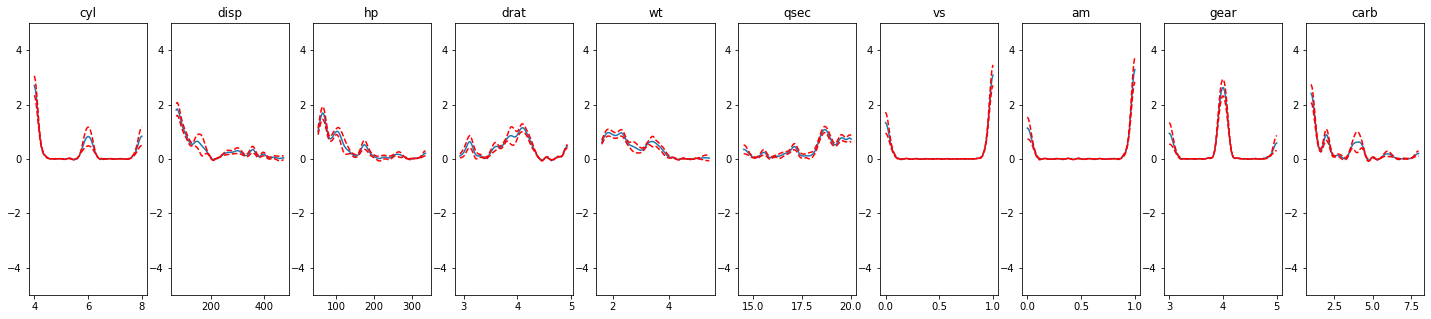

In [18]:
partial_dependence_grid(lgam3, X_train, y_range = (-5,5))

# Ultra Flexibilidad

Es posible ajustar distintos tipos de smoothing functions dependiendo del tipo de dato del predictor

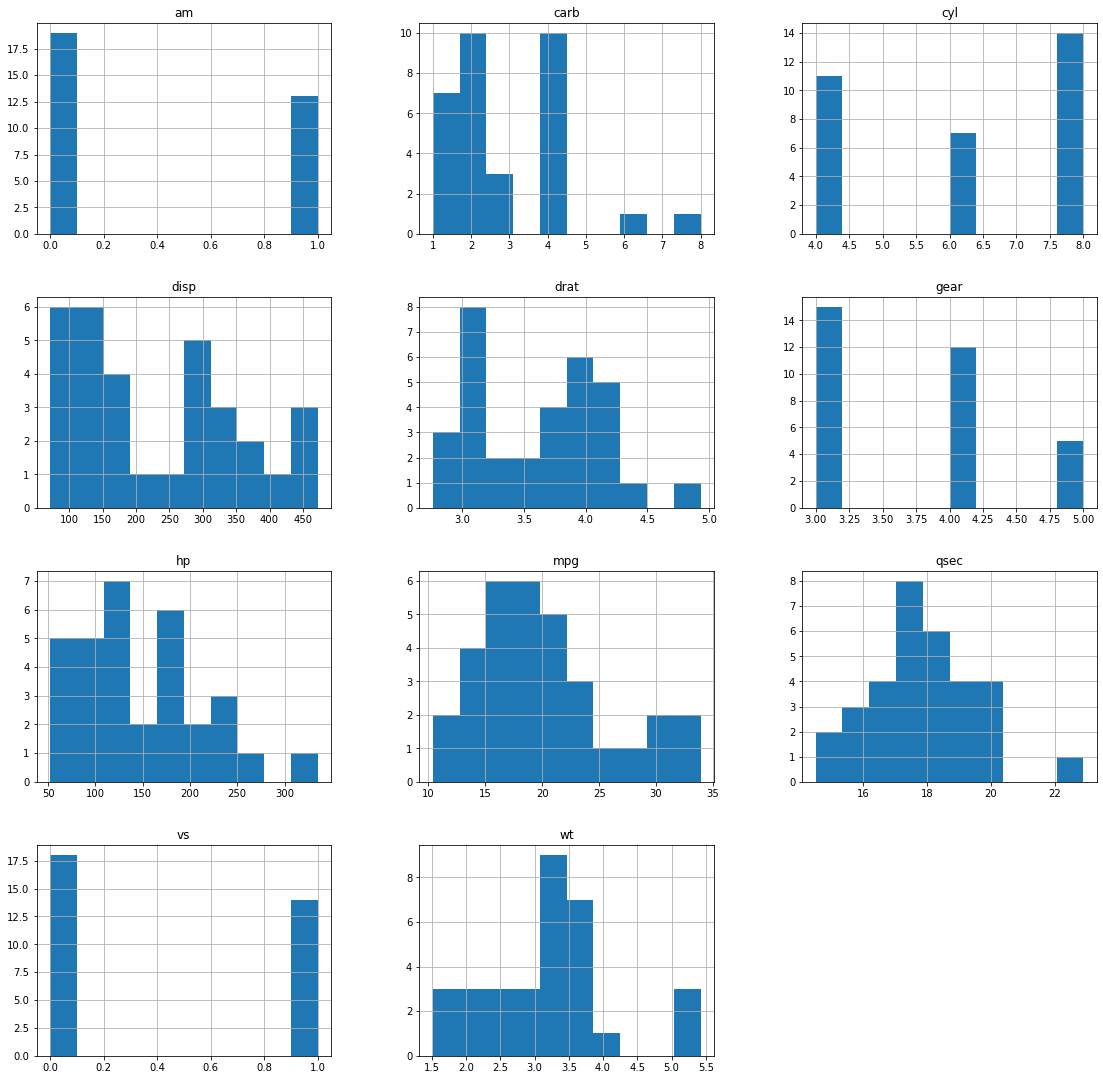

In [19]:
cars.hist(figsize = (19,19))
plt.show()

In [20]:
cat = ['am', 'vs', 'carb', 'cyl', 'gear'] # categorías
ind_cat = [index for index, name in enumerate(X_train.columns) if name in cat]
ind_num = [index for index, name in enumerate(X_train.columns) if name not in cat]
print(f'Categorías {ind_cat}')
print(f'Numeros {ind_num}')

Categorías [0, 6, 7, 8, 9]
Numeros [1, 2, 3, 4, 5]


In [21]:
lgam4 = LinearGAM(f(0)+s(1)+s(2)+s(3)+s(4)+s(5)+f(6)+f(7)+f(8)+f(9)) # no muy escalable
compute_model(lgam4,'r') # not very scalable

RMSE test: 3.089208795790377


In [22]:
lgam4.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.1705
Link Function:                     IdentityLink Log Likelihood:                                     -62.62
Number of Samples:                           22 AIC:                                              137.5811
                                                AICc:                                             143.5483
                                                GCV:                                               11.0071
                                                Scale:                                              6.4778
                                                Pseudo R-Squared:                                   0.8738
Feature Function                  Lam

C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [23]:
#partial_dependence(lgam5, X_train)

# CLASIFICACIÓN

Pequeño ejemplo de un modelo Clasificación

In [24]:
df = pd.read_csv('titanic.csv', index_col = 'PassengerId')
df.shape

(891, 12)

In [25]:
new_df = df.select_dtypes(np.number).fillna(df.Age.mean()).copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns = 'Survived'), new_df.Survived, test_size = 0.3)

In [27]:
logam2 = LogisticGAM()
logam2.gridsearch(X_train.to_numpy(), y_train.to_numpy(), n_splines=np.arange(4,15), lam = list(np.logspace(-3,3,11))*5)

 36% (218 of 605) |#######               | Elapsed Time: 0:00:08 ETA:   0:00:15C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\pygam\pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\pygam\links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
C:\Users\fata2810\AppData\Local\Continuum\anaconda3\envs\MLprojects\lib\site-packages\pygam\links.py:134: RuntimeWarning: invalid value encountered in true_divide
  ret

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

In [28]:
y_pred = logam2.predict(X_test)
y_pred

array([ True, False,  True, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False, False,  True,  True, False, False,  True, False,
       False, False, False,  True,  True, False, False, False, False,
       False,  True,  True, False,  True, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False, False, False, False,  True, False,  True, False,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False,  True,  True, False,
        True, False,  True, False, False, False,  True, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False,  True,

In [29]:
print(accuracy_score(y_pred, y_test))

0.7425373134328358


In [30]:
logam3 = LogisticGAM(f(0)+ s(1)+s(2)+s(3)+s(4))
compute_model(logam3, 'c')

Accuracy 0.7350746268656716


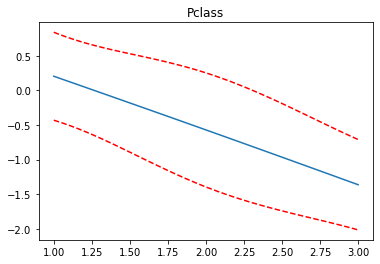

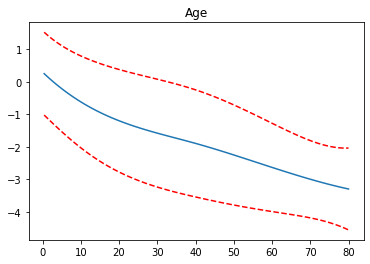

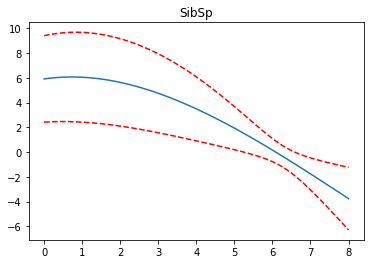

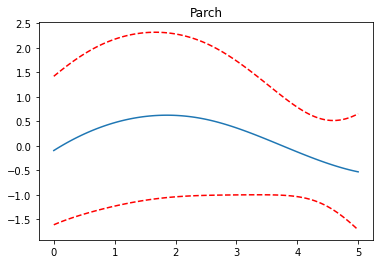

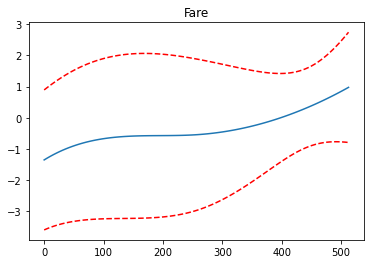

In [31]:
partial_dependence(logam2, X_train)